In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import scipy.io as sio
from dataclasses import dataclass
from typing import List, Tuple
import os
from dotenv import load_dotenv
load_dotenv()
import tidy3d as td
from tidy3d import web
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from natsort import natsorted
import numpy as np
import matplotlib.animation as animation
import xarray as xr
import h5py
import imageio
import matplotlib
import gc
import sys
import io
import matplotlib.colors as mcolors
import matplotlib.patches as patches
from scipy.optimize import curve_fit
import scipy.integrate


# Assuming /AutomationModule is in the root directory of your project
sys.path.append(os.path.abspath(rf'H:\phd stuff\tidy3d'))

from AutomationModule import * 

import AutomationModule as AM
plt.rcParams.update({'font.size': 12})  

tidy3dAPI = os.environ["API_TIDY3D_KEY"]
plt.rc('font', family='Arial')


In [2]:
file = rf"H:\phd stuff\tidy3d\output\LSU Data\transmission_different_permmitivities_thickness_4.h5"
with h5py.File(file, 'r') as h5f:
    data = {
            'transmission_right':h5f["transmission_right"][:],
            'transmission_left':h5f["transmission_left"][:],
            'name':h5f["name"],
            'nu(a/lambda)':h5f["nu(a/lambda)"][:],
            "raw_freqs(Hz)":h5f["raw_freqs(Hz)"][:],
            "sizes":h5f["sizes"][:],
            "cell_size":h5f["cell_size"],
            "a":h5f["a"],
            "eps":h5f["eps"][:]
                        
            }

In [3]:
a=3.4

In [4]:
print(data["eps"][4])
print(np.shape(data["transmission_right"]))
print(np.shape(data["sizes"]))

9.0
(1, 22, 200)
(22,)


In [5]:
transmission_eps_9 = data["transmission_right"][0,:,:]
transmission_eps_9_left = data["transmission_left"][0,:,:]

In [6]:
np.shape(transmission_eps_9)

(22, 200)

In [7]:
data["sizes"]*14.3

array([ 0.   ,  0.429,  0.715,  1.001,  1.43 ,  2.145,  2.86 ,  3.575,
        4.29 ,  5.72 ,  7.15 ,  8.58 , 10.01 , 11.44 , 12.87 , 14.3  ,
       17.16 , 18.59 , 21.45 , 24.31 , 27.17 , 28.6  ])

<>:7: SyntaxWarning: invalid escape sequence '\m'
<>:7: SyntaxWarning: invalid escape sequence '\m'
C:\Users\HernandF\AppData\Local\Temp\ipykernel_57840\2846164142.py:7: SyntaxWarning: invalid escape sequence '\m'
  plt.title("Transmission Spectra a=3.4$\mu m$ n=3 L=14.3$\mu m$")
C:\Users\HernandF\AppData\Local\Temp\ipykernel_57840\2846164142.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


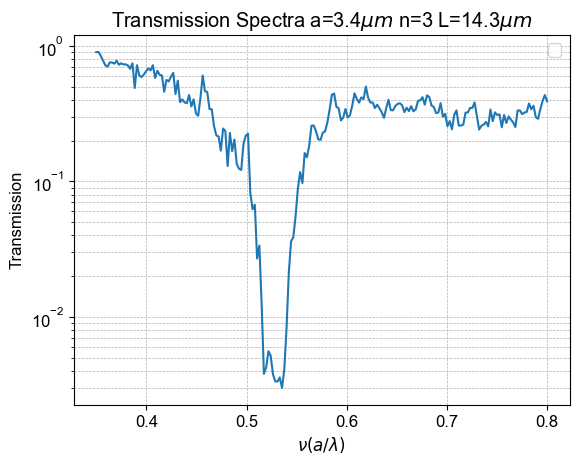

In [8]:
plt.plot(data["nu(a/lambda)"],transmission_eps_9[15])
plt.ylabel("Transmission")
plt.xlabel(rf"$\nu (a/\lambda)$")
plt.yscale("log")
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.legend()
plt.title("Transmission Spectra a=3.4$\mu m$ n=3 L=14.3$\mu m$")
plt.show()

In [9]:
for i,item in enumerate(data["sizes"]):
    plt.plot(data["nu(a/lambda)"],transmission_eps_9[i],"o",label="right monitor")
    plt.plot(data["nu(a/lambda)"],transmission_eps_9_left[i],"o",label="left monitor")
    plt.ylabel("Transmission")
    plt.xlabel(rf"$\nu$")
    plt.yscale("log")
    plt.legend()
    plt.title(rf"{item*14.3/3.4}[L/a]")
    plt.savefig(rf"H:\phd stuff\tidy3d\output\LSU Data\Convergence\convergence 20250210\fig_{i}")
    plt.close()

In [10]:
#Fit initial decay T_b(L) to find the mean free path 
def T_b(L,l):
    return (-L/l)

In [11]:
sizes_slab = (data["sizes"]*14.3)
sizes_slab = sizes_slab[sizes_slab<=a]
np.shape(sizes_slab)[0]

7

In [12]:
sizes_slab

array([0.   , 0.429, 0.715, 1.001, 1.43 , 2.145, 2.86 ])

In [13]:
import jax
import jax.numpy as jnp
from jaxopt import ScipyMinimize
import jaxopt
import matplotlib.pyplot as plt
jax.config.update("jax_enable_x64", True)

In [14]:
l_values = []

for i,item in enumerate(data["nu(a/lambda)"]):
    model = lambda params,L: T_b(L,params[0])
    def loss_fn(params):
        y_pred = model(params, (data["sizes"][:10]*14.3/a))
        return jnp.mean((y_pred - jnp.log(transmission_eps_9[:10,i]))**2)
    

    initial_params = jnp.array([1e-2], dtype=jnp.float32)
    optimizer = jaxopt.ScipyBoundedMinimize(fun=loss_fn,maxiter=10000)
    result = optimizer.run(initial_params, bounds=([1e-4],[5e-1]))
    optimal_params = result.params

    # popt,_ = curve_fit(T_b,(data["sizes"][:9]*14.3/a),np.log(transmission_eps_9[:9,i]),bounds=([1e-4],[1]))

    l_values.append(optimal_params[0])
   



In [15]:
def T_d(L,xi,T_0):
    z0 = 3.25 
    return jnp.log(T_0 * jnp.exp(-L/xi))
    # return T_0*(l*(1+z0)/(1+2*z0/xi)) * np.exp(-L/xi)

In [16]:
xi_values = []
T_0_values = []

for i,item in enumerate(data["nu(a/lambda)"]):
    T_d_calculation = lambda L,xi,T_0: T_d(L,xi,T_0)
    model = lambda params,L: T_d(L,params[0],params[1])
    def loss_fn(params):
        y_pred = model(params, jnp.log(data["sizes"][10:]*14.3/a))
        return jnp.mean((y_pred - jnp.log(transmission_eps_9[10:,i]))**2)
    

    initial_params = jnp.array([3e-1,5e-1], dtype=jnp.float32)
    optimizer = jaxopt.ScipyBoundedMinimize(fun=loss_fn,maxiter=10000)
    result = optimizer.run(initial_params,bounds=([1e-1,1e-1],[10,9e-1]))
    optimal_params = result.params

    # popt,_ = curve_fit(T_d_calculation,np.log(data["sizes"]*14.3/a)[10:],np.log(transmission_eps_9[10:,i]),bounds=([2,1e-1],[100,9e-1]))
    xi_values.append(optimal_params[0])
    T_0_values.append(optimal_params[1])


In [17]:
for i,item in enumerate(data["nu(a/lambda)"]):
    if np.mod(i,1) == 0:
        plt.plot(data["sizes"]*14.3/a,np.exp(T_b(data["sizes"],l_values[i])),"--", label="$T_b =e^{-L/l}$")
        plt.plot(data["sizes"]*14.3/a,np.exp(T_d(data["sizes"],xi_values[i],T_0_values[i])),"--", label=rf"$T_0 \times T_d$")
        plt.plot(data["sizes"]*14.3/a,transmission_eps_9[:,i],"o",label="FDTD Data")
        plt.ylabel("Transmission")
        plt.xlabel("Slab thickness L/a")
        plt.legend()
        plt.yscale("log")
        plt.xscale("log")
        plt.title(rf"$\nu={item:.4g}$")
        plt.grid(True, which="both", ls="--", linewidth=0.5)
        plt.savefig(rf"H:\phd stuff\tidy3d\output\LSU Data\decay T(L)\fig_{i}")
        plt.close()